# Tarea 4: Algoritmos Evolutivos (Genéticos Básicos)
## Área Académica de Ingeniería Mecatrónica - MT8008: Inteligencia Artificial
### Autores: Marco Rodríguez Barboza y Carlos Valverde Díaz 

En la presente notebook se mostrará el proceso de implementación de una red evolutiva utilizada para un proceso de optimización, basada en el paradigma evolutivo de la Inteligencia Artificial.

Esta implementación se hizo con el uso de librerías especializadas en algoritmos genéticos, específicamente con `PyGAD` [[1]](https://github.com/ahmedfgad/GeneticAlgorithmPython). A su vez, debido a que se hará uso de análisis de sistemas, el uso de código de MATLAB simplifica mucho el proceso. Por ello, las partes del código que involucren el manejo de funciones de transferencia o cálculos relacionados las partes del sistema se harán en MATLAB, y se integrarán en esta notebook mediantes sus códigos `.m` y la librería `matlab.engine` de Python [[2]](https://la.mathworks.com/help/matlab/matlab-engine-for-python.html). 

### Descripción del problema:

Se cuenta con el siguiente sistema, descrito por las funciones de transferencia $G_1, G_2, G_3, H_1, H_2 y H_3$. 

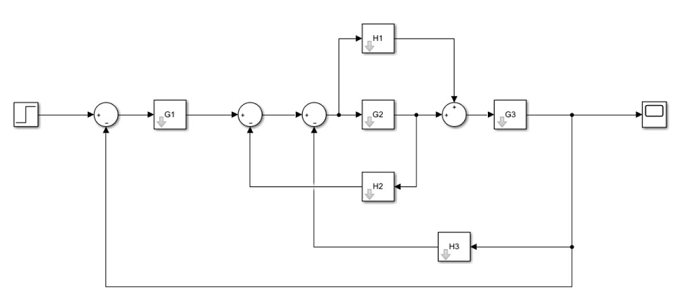

De forma que las funciones son:

\begin{equation}
    G_1(s) = \frac{A_1}{B_1 \cdot s \cdot (s+C_1)}\\
\end{equation}

\begin{equation}
    G_2(s) = \frac{A_2 \cdot s}{B_2 \cdot s \cdot (s+\frac{C_2}{s}) + D_2}
\end{equation}

\begin{equation}
    G_3(s) = \frac{A_3 \cdot s \cdot (s+C_3)}{B_3}
\end{equation}

\begin{equation}
    H_1(s) = K_1 \cdot (1 + F_1 \cdot s)
\end{equation}

\begin{equation}
    H_2(s) = K_2 \cdot (1 + F_2 \cdot s)
\end{equation}

\begin{equation}
    H_3(s) = K_3 \cdot s
\end{equation}

El objetivo entonces es encontrar un vector de valores en el espacio de parámetros $(A_x, B_x, C_x, D_x, F_x, K_x)$ que satisfaga que la salida del sistema, ante una entrada de escalón unitario, sea tal que se tenga un sobreimpulso del 20% en un tiempo de 1s. Es claro que se necesita de las herramientas de análisis de sistemas para resolver este ejercicio, por lo que se describe ello a continuación:

#### Obtención de la función de transferencia del sistema $M(s)$:

Aplicando una representación del diagrama de bloques de la Figura anterior en diagrama de flujo de señal (SFG), se obtiene el siguiente resultado: 





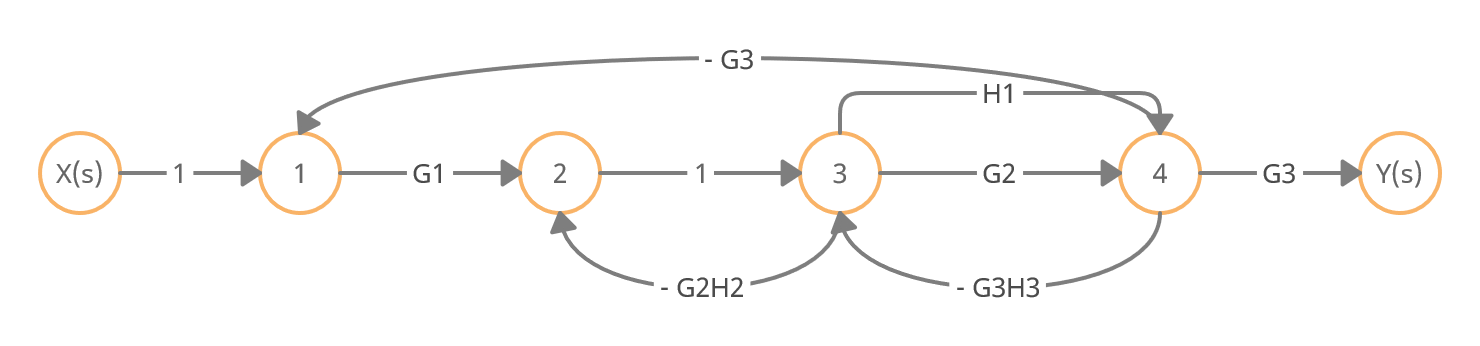

Si se aplica la Fórmula de Ganancia para SFG, dada por:

\begin{equation}
    M(s) = \frac{Y(s)}{X(s)} = \frac{1}{\Delta} \sum _{k=1} ^N M_k \cdot \Delta_k
\end{equation}

Donde $M(s)$ es la función de transferencia del sistema, $N$ es el número de trayectorias directas entre la entrada y la salida, $M_k$ es la ganancia de la k-ésima trayectoria directa, $\Delta$ es el determinante del diagrama y $\Delta_k$ es el cofactor del determinante de la k-ésima trayectoria directa. 

Entonces, para el SFG de la figura: 

* Se tienen dos trayectorias directas: $G_1 \cdot G_2 \cdot G_3$ y $G_1 \cdot H_1 \cdot G_3$, cuyos $\Delta_k$ asociados son $1$ para ambas trayectorias. 

* Se tienen 5 mallas individuales: $G_1 \cdot G_2 \cdot -G_3$ | $-G_2 \cdot H_2$ | $-G_3 \cdot H_3 \cdot G_2$ | $-G_3 \cdot H_3 \cdot H_1$ | $G_1 \cdot H_1 \cdot -G_3$

* El determinante general es $\Delta = 1 + G_1 G_2 G_3 + G_2 H_2 + G_2 G_3 H_3 + G_3 H_1 H_3 + G_1 G_3 H_1 $

Por consiguiente, se tiene que la función de transferencia del sistema es:

\begin{equation}
    M(s) = \frac{Y(s)}{X(s)} = \frac{G_1 G_2 G_3 + G_1 H_1 G_3}{1 + G_1 G_2 G_3 + G_2 H_2 + G_2 G_3 H_3 + G_3 H_1 H_3 + G_1 G_3 H_1}
\end{equation}

Como es claramente visible, la función es increíblemente compleja y depende de las definciones de $G_k$ y $H_k$, que a su vez dependen de los 15 parámetros por variar. Por ello, se utilizará el kernel de Matlab para simular el comportamiento del sistema en función de los parámetros que se le entreguen. Posteriormente se mostrará el código de esta implementación.

En cuanto a la estabilidad del sistema, esta se prueba en el código de Matlab bajo el criterio de que TODOS los polos de la función de transferencia deben tener parte real negativa $(Re(s) < 0)$. Esto pues la señal de escalón es una señal derecha, y bajo el supuesto de tener un sistema causal, en el plano s se debe tener una ROC derecha que incluya al eje $j\omega$ para que el sistema sea estable. Ello siempre es posible cuando todos los polos tienen parte real negativa.  

### ¿Qué es un algoritmo evolutivo?

Como se mencionó, el problema planteado se resolverá con un paradigma de la Inteligencia Artificial basado en el fenómeno natural de la evolución biológica de las especies en el tiempo. De esta manera, la entrada del algoritmo es un conjunto de soluciones propuestas a ese problema (erróneas, claramente). La cantidad de soluciones es lo que se conoce como **población inicial**. Para fines de codificación, dichas soluciones se acomodan de cierta forma (como un array, por ejemplo) para componer los **cromosomas** del problema. Cada elemento del cromosoma recibe el nombre de **gen**, que acarrean la información para solucionar el problema.

Estos cromosomas se evalúan en el problema para obtener un resultado, que se compara y evalúa su certeza con una **función objetiva o de calidad** que dice cuantitativamente si la solución es buena, regular o mala, con base en los resultados esperados. Se denomina **espacio de alelos** a los rangos o posibles valores que cada gen va a tener. El **genotipo** constituye la composición genética de los cromosomas que se hereda de los padres, mientras que el fenotipo trata al conjunto caracterpisticas que un individuo adquiere al interactuar con un **entorno**, y define cómo se verá el individuo.

La idea entonces radica en que, mediante mecanismos definidos, se descarten los cromosomas con mala calidad y se itere nuevamente los resultados con aquellos cromosomas que tuvieron mejores resultados. Así, se generan **épocas** que tienen una población que se pondrá a prueba para generar la nueva población de la próxima generación. Ese descarte se hace mediante técnicas de:

* Selección: solo pasan los mejores evaluados bajo cierto criterio.
* Recombinación: reacomodo de genes bajo un criterio que genera la nueva población.
* Mutación: cambios de los genes bajo condiciones probabilísticas.

El proceso se repite durante n épocas y al final de cada una se obtiene al cromosoma mejor evaluado de la población, quien se compara con un **criterio de parada** definido por el diseñador para determinar si ya se encuentra la solución óptima o cercana del problema. La siguiente figura muestra un diagrama de este tipo de algoritmo.


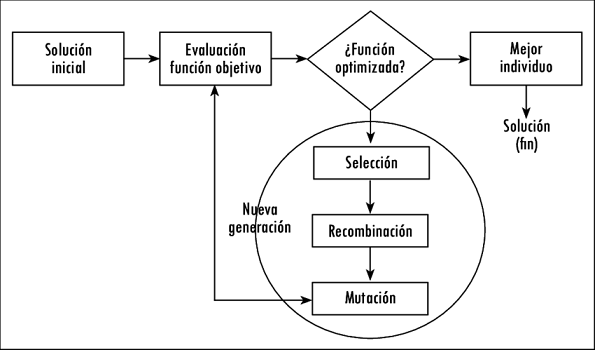

### Descripción de las variables genéticas ajustadas al problema:

#### Cromosoma: 

Se define al cromosoma como la codificación de la solución del problema, que será el array de los 15 genes o valores del espacio $(A_x, B_x, C_x, D_x, F_x, K_x)$. El espacio de alelos será el mismo para todos los genes ya que son todos múmeros reales. Así, el cromosoma entonces tiene la forma:

\begin{equation}
    X = ( A_1 , A_2 , A_3 , B_1 , B_2 , B_3 , C_1 , C_2 , C_3 , D_2 , F_1, F_2 , K_1 , K_2 , K_3 )
\end{equation}

#### Función de calidad:

Para que se tenga idea de qué tan buena es la salida del sistema, se debe comparar el tiempo $t$ y magnitud $y$ de sobreimpulso de esta con los valores esperados: $t_p = 1s$ y $y_p = 20\%$, respectivamente. Por consiguiente, se plantea que la función sea: 

\begin{equation}
    f (t , y) = |t-t_p| + |y-y_p|
\end{equation}

$t$ y $y$ se obtendrán con comandos de Matlab: `PeakTime` y `Overshoot`. Overshoot da el porcentaje de sobreimpulso, y debido a que PyGAD maneja el problema como una optimización se recomienda dar un resultado negativo. Por lo tanto, ya con los valores conocidos y normalizando la función de calidad queda como:

\begin{equation}
    f (t , y) = - |t-1| - \left|\frac{y}{20}-1\right|
\end{equation}

#### Criterio de parada: 

Se define que será cuando $f(t,y) \geq -0.1$, dada la complejidad del sistema y la sensibilidad de este ante las variaciones en las constantes. De esta manera, el valor del tiempo rondará entre 0.9 y 1.1 segundos, mientras que el valor de la sobreoscilación estará entre el 18% y el 22%.

#### Relación genotipo-fenotipo:

En este caso se tendrá una red evolutiva en donde una cierta cantidad de cromosomas serán tomados como padres a partir de una selección de tipo torneo, donde se seleccionan los mejores individuos para que hereden las características buenas a los hijos. Por lo tanto, el genotipo de esta aplicación estará dado por las características heredadas del cromosoma padre. Por su parte, el fenotipo lo adquirá el cromosoma al pasar por la interacción con el sistema, mediante procesos de actualización y modificación debido a los resultados obtenidos. 

### Implementación en código:

#### Códigos `.m` utilizados:

Estos pueden ser accedidos en el siguiente link, para su revisión y descarga: [Archivos .m](https://drive.google.com/drive/folders/1IcZdu2H0iThuLZOqYGnXBtXeSNNOTX_g?usp=sharing). Se recomienda dejarlos en la misma carpeta que la notebook.

* Función objetiva: dado que la función objetiva depende de los valores de tiempo y magnitud del sobreimpulso de la respuesta del sistema, se montó el archivo `fObj.m` que modela el sistema con base en la función de transferencia y lo prueba con el escalón unitario y el vector cromosoma $X$ dado, según lo descrito en el enunciado.

* Evaluación del fenotipo: el archivo `Salida.m` permite obtener el vector de salida del sistema para un tiempo de 100 segundos, esto con el fin de evaluar el fenotipo obtenido luego del entrenamiento de la red evolutiva.

#### Librerías utilizadas:

Las librerías más importantes de este código son `pygad`, útil para la implementación de la red evolutiva, y `matlab.engine` para poder correr los códigos de simulación. Otras usadas se muestran en el siguiente bloque de código:

In [1]:
import matplotlib.pyplot as plt # Imprimir resultados
import matlab.engine # Conectar con matlab
import pygad # Implementación de la red evolutiva
import numpy as np 
import random 
import math 

# Se conecta con el entorno de matlab
eng = matlab.engine.start_matlab()

#### Llamado de la función de calidad:

Se llama a la función de calidad de Matlab al pasarle un cromosoma en específico y obtener su evaluación. Esta función se usa en el entrenamiento del algoritmo.

In [2]:
def funcCalidad(solution, solution_idx):
    # Se selecciona cada gen del cromosoma pasado a la función
    A1 = float(solution[0])
    A2 = float(solution[1])
    A3 = float(solution[2])
    B1 = float(solution[3])
    B2 = float(solution[4])
    B3 = float(solution[5])
    C1 = float(solution[6])
    C2 = float(solution[7])
    C3 = float(solution[8])
    D2 = float(solution[9])
    F1 = float(solution[10])
    F2 = float(solution[11])
    K1 = float(solution[12])
    K2 = float(solution[13])
    K3 = float(solution[14])

    # Se llama a la función de matlab para realizar la operación de la función objetiva
    salida = eng.fObj(A1,A2,A3,B1,B2,B3,C1,C2,C3,D2,F1,F2,K1,K2,K3)

    # Se retorna el valor de la función objetiva, con un menos, para adecuarse a la optimización de PyGAD.
    return -salida

#### Impresión de un resultado:

Con esta función se puede obtener la gráfica de la salida del sistema para un cromosoma dado, con el fin de evaluar gráficamente la utilidad de dicho cromosoma. El parámetro `tmod` permite colocar el rango de tiempo que se quiere observar en la gráfica, aplicando un "zoom" en el eje horizontal.

In [3]:
def imprimirResultado(solution, tmod):
    # Se selecciona cada gen del cromosoma pasado a la función
    A1 = float(solution[0])
    A2 = float(solution[1])
    A3 = float(solution[2])
    B1 = float(solution[3])
    B2 = float(solution[4])
    B3 = float(solution[5])
    C1 = float(solution[6])
    C2 = float(solution[7])
    C3 = float(solution[8])
    D2 = float(solution[9])
    F1 = float(solution[10])
    F2 = float(solution[11])
    K1 = float(solution[12])
    K2 = float(solution[13])
    K3 = float(solution[14])

    # Se obtiene el array con los valores de salida
    y = eng.Salida(A1,A2,A3,B1,B2,B3,C1,C2,C3,D2,F1,F2,K1,K2,K3,tmod)

    # Se crea un espacio lineal con los valores del tiempo
    t = np.linspace(0, tmod, 1000)

    # Se cambia el tipo de dato a un arreglo numpy
    y = np.array(y)

    # Se imprimen los resultados
    plt.plot(t, y)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Salida")
    plt.grid()
    plt.show()

#### Definición de la función de parada

Toma como entrada la generación de cromosomas y extrae de ella al mejor individuo. De obtenerse un individuo con calidad mayor a -0.1, se detiene la ejecución del algoritmo. 

In [4]:
def stopFunction(instance):
    # Se obtiene la calidad de la mejor solución
    fit = instance.best_solution()[1]
    # Se obtiene el índice de la mejor solución
    index = instance.best_solution()[2]
    print(instance.generations_completed, "Mejor solución: {fit}".format(fit=fit), index)
    # Condición de parada
    if fit >= -0.1:
        return "stop"


#### Definición de hiperparámetros de la ejecución.

Se seleccionan los hiperparámetros del algoritmo, que determinarán el éxito de la evolución. En los comentarios del código se adjuntan explicaciones pertinentes a cada uno de ellos. Estos serán variados para obtener el mejor resultado posible, y en el bloque se adjuntan los que lograron lo anterior. En la sección de análisis se incluye la descripción completa del proceso de decisión seguido para colocar estos parámetros.

In [62]:
# Número máximo de iteraciones o de generaciones
num_generations = 200

# Número de soluciones de la población que se seleccionan como padres
num_parents_mating = 10

# Función objetiva (dos parámetros: la solución por probar y el índice de esta en la población). 
# Siempre es la función establecida por los diseñadores.
fitness_func = funcCalidad

# Número de cromosomas por población. Se ignora si se carga una población inicial.
sol_per_pop = 50

# Número de genes en cada cromosoma. Siempre 15 pues hay 15 constantes. Se ignora si se carga una población inicial.
num_genes = 15

# Tipo de genes. Siempre de tipo float para este problema. 
# types: int, float, and numpy.int/uint/float(8-64)
gene_type = float

# Valor más bajo posible del espacio de alelos
init_range_low = -1

# Valor más alto posible del espacio de alelos
init_range_high = 1

# Numero de padres que se quedan (-1=todos, default)
keep_parents = 5

''' 
Tipo de selección de padres

"sss"(for steady-state selection)
'"rws"(for roulette wheel selection)
"sus"(for stochastic universal selection)
"rank"(for rank selection)
"random"(for random selection)
"tournament"(for tournament selection)
'''

# Se escoge tournament como método de selección de los mejores cromosomas.
parent_selection_type = "tournament"

''' 
Operaciones de cruce genético

"single_point" (for single-point crossover)
"two_points" (for two points crossover)
"uniform" (for uniform crossover)
"scattered" (for scattered crossover)
'''

# Se selecciona el cruce uniforme como método de recombinación.
crossover_type = "uniform"

'''
Tipo de mutación

"random" (for random mutation)
"swap" (for swap mutation)
"inversion" (for inversion mutation)
"scramble" (for scramble mutation)
"adaptive" (for adaptive mutation)
'''

# Se escoge el método de mutación aleatorio, con un porcentaje de probabilidad de ocurrencia
mutation_type = "random"
mutation_probability = 0.15

# No se admite genes duplicados pues no interesa evaluar dos veces al mismo cromosoma
allow_duplicate_genes = False

# Función que se ejecuta al finalizar cada generación. Siempre es la función de parada para ver si ya se cumplió el objetivo.
on_generation = stopFunction

# Comente este bloque si no desea precargar una población inicial en lugar de generarla.

# Se carga uno anteriormente creado
load_ga_instance = pygad.load(filename='Mejor_Caso')

# Población inicial
initial_population = load_ga_instance.population

#### Construcción del algoritmo evolutivo con `pygad.GA`

Se construye entonces el modelo con los parámetros definidos en el bloque anterior.

In [63]:
# Construcción del algoritmo evolutivo. Si no se desea cargar una población inicial, 
# comente la primera línea y descomente el resto

ga_instance = pygad.GA(initial_population=initial_population,
                       num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       #sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       #gene_type=gene_type,
                       #init_range_low=init_range_low,
                       #init_range_high=init_range_high,
                       keep_parents=keep_parents,
                       parent_selection_type=parent_selection_type,
                       mutation_probability=mutation_probability,
                       crossover_type=crossover_type,
                       allow_duplicate_genes=allow_duplicate_genes,
                       on_generation=on_generation)

#### Ejecución del algoritmo evolutivo con `.run`

En los resultados de consola se muestra el valor de la calidad de la mejor solución de dicha generación, seguido del índice en donde se ubica dicha solución. Esto sirve para ver la evolución de la calidad en función de las generaciones. 

1 Mejor solución: -8.493482894824922 0
2 Mejor solución: -8.493482894824922 0
3 Mejor solución: -8.493482894824922 0
4 Mejor solución: -8.493482894824922 0
5 Mejor solución: -8.10771897258 26
6 Mejor solución: -8.10771897258 0
7 Mejor solución: -8.493482894824922 0
8 Mejor solución: -8.10771897258 1
9 Mejor solución: -7.815318496910784 23
10 Mejor solución: -8.10771897258 0
11 Mejor solución: -7.815318496910784 4
12 Mejor solución: -7.815318496910784 0
13 Mejor solución: -7.815318496910784 0
14 Mejor solución: -7.474893007167116 48
15 Mejor solución: -4.733493535774743 11
16 Mejor solución: -6.103518484386885 24
17 Mejor solución: -4.733493535774743 4
18 Mejor solución: -7.1701977654108955 2
19 Mejor solución: -4.733493535774743 3
20 Mejor solución: -4.733493535774743 0
21 Mejor solución: -6.103518484386885 0
22 Mejor solución: -3.9114850198947204 20
23 Mejor solución: -3.9114850198947204 0
24 Mejor solución: -3.9114850198947204 0
25 Mejor solución: -3.9114850198947204 1
26 Mejor soluc

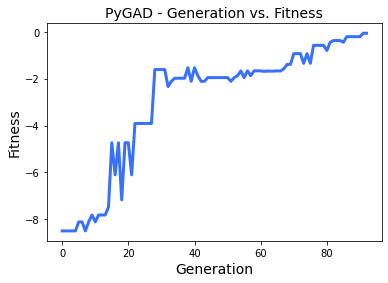

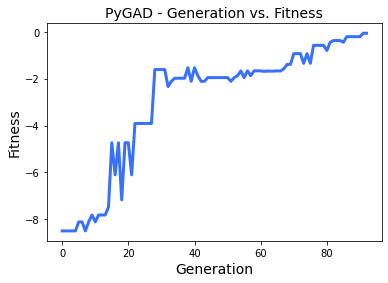

In [64]:
ga_instance.run()

#Luego de ejecutado, se obtiene la gráfica de la calidad en función de las generaciones
ga_instance.plot_fitness() 

#### Prueba de la salida del mejor individuo

Con este bloque se muestra la gráfica del mejor individuo de la última población de la ejecución anterior. Se obtiene los datos de dicho individuo y se obtiene la gráfica de la salida del sistema que generan.

Mejor individuo del evolutivo: [-1.71237515 -4.95348963 -1.74416662  0.11091275 -0.39450991 -2.10459055
  1.00154041  1.71807514  0.52230826  0.44037606  0.20820449  0.37277306
  0.70284    -2.59778281 -0.32009094] 
Calidad de la mejor solución = -0.06626429162983027
Índice de la mejor solución: 10


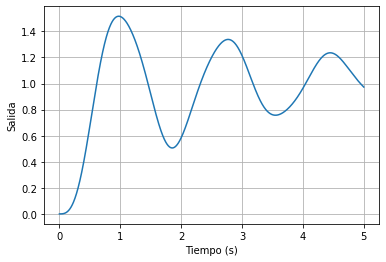

In [71]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Mejor individuo del evolutivo: {solution} ".format(solution=solution))
print("Calidad de la mejor solución = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Índice de la mejor solución: {solution_idx}".format(solution_idx=solution_idx))

# Se guarda el resultado del entrenamiento
#filename = 'Optimizado'
#ga_instance.save(filename=filename)

imprimirResultado(solution, 5)

### Análisis de la construcción del modelo: hiperparámetros

En este problema no se da una población inicial, por lo que se recurre a formarla aleatoriamente. Sin embargo, esta población puede formarse de manera que se obtengan resultados decentes después de un número de generaciones, con el fin de guardar la última población como "semilla" generadora para próximas iteraciones. Por lo tanto, se describe a continuación cómo se obtuvo esta primera población inicial a partir de la formación aleatoria de PyGAD.

* Dado el tiempo de ejecución y usualmente rápida crecida de la calidad en unas cuantas primeras generaciones, para estas primeras ocasiones se define siempre un total de **50 generaciones** con **50 cromosomas** por población. De esos 50, se seleccionará el 20% como padres, es decir, se tienen **10 cromosomas padre**. Siempre se tendrán **15 genes de tipo float** por cromosoma, dadas las 15 constantes del sistema que pueden tomar cualquier valor real. La mitad de los padres se queda, el resto se descarta.

* Dado que se tiene un problema de optimización, se establece que la mejor selección será por torneo, dado que así se garantiza escoger los mejores individuos para ser padres. 

* Se define un espacio de alelos inicial entre -1 y 1.

#### Definición de la recombinación y mutación

1. Se define recombinación uniforme y mutación aleatoria con probabilidad del 0.5% para explorar los valores de las constantes, pero sin meter mucha presión selectiva. Al utilizar los hiperparámetros anteriores con este espacio, se obtuvo terribles resultados con calidades de -7606, como se ve en la gráfica (a) de la figura adjunta. Esto lo que indica es que no se está obteniendo mejoras evolutivas, por lo que se aumentará la presión selectiva. 

2. Se mantiene lo mismo pero se aumenta la probabilidad de mutación al 5%. Solo con ese cambio se logró llegar a una calidad mayor a -10, por lo que se acerca el problema poco a poco a la condición de parada. Se tiene la calidad en la gráfica (b) de la figura adjunta. 

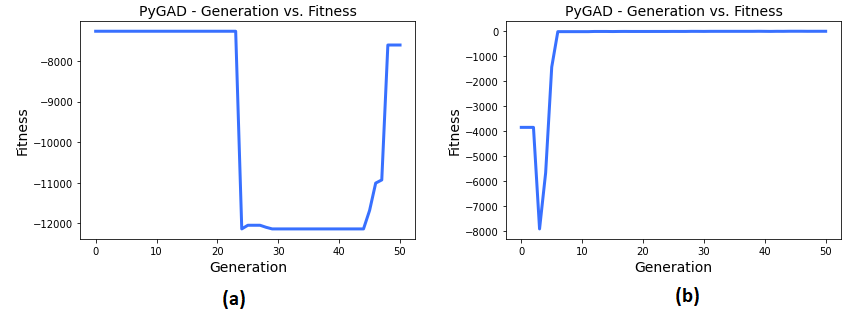

Con esto se confirma que se desea tener una presión selectiva alta, dado que se busca el mejor set de constantes para obtener los resultados precisos. Al calcular el resultado del mejor individuo de la segunda prueba, se tiene la siguiente información, obtenida con el bloque de evaluación:

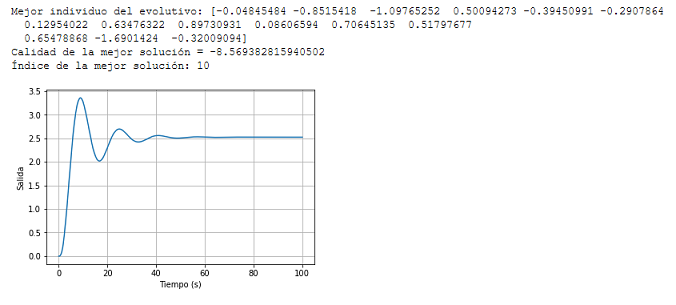





Nótese que con este individuo se logra una sobreoscilación muy cercana al 25% extra del valor final (que como se ve, se asienta en 2.5, pero ocurre cercano a las 10s, por lo que aún se debe mejorar la población. 

A su vez, se confirma que aumentar el tamaño de la población o de las generaciones sería innecesario, ya que con este valor elegido inicialmente se obtiene una convergencia correcta de la calidad hacia los valores cercanos a cero en pocas generaciones. Por ello, se mantienen esos hiperparámetros. 

3. ¿Qué se puede mejorar? Probemos cambiando la selectividad por la variabilidad. Se cambiará a recombinación por dos puntos y mutación aleatoria con probabilidad del 5%, para tener mayores cambios en los genes. Como se ve en la figura adjunta, la calidad inicial es peor y no se logra llegar al buen resultado obtenido por la recombinación uniforme. Por tanto, esto reconfirma que el problema se ajusta a un caso de alta presión selectiva. 

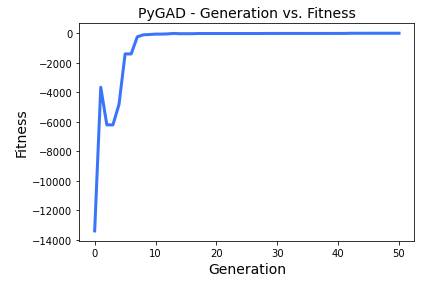

Por consiguiente, todo parece apuntar a que lo más correcto será guardar la población obtenida en la 50° iteración el segundo intento como población inicial, y obtener resultados desde allí. Se guarda en el archivo `Mejor_Caso.pkl`. 

### Ejecución a partir de la población inicial seleccionada

Entonces, ya se cuenta con una población inicial que describe valores que medianamente aproximan el comportamiento final esperado. Por consiguiente, se debe cambiar la variabilidad de los datos por una mayor selectividad: se busca el mejor de los mejores resultados. Por ello en bloque de hiperparámetros se aplican los cambios para cargar la población inicial. A partir de ahora se eliminará los límites del espacio de alelos, para que los genes tomen la forma que mejor se adapte. A su vez, se aumenta la tasa de mutación a un 15%. Con estos cambios (y dejando el resto de parámetros iguales, se obtiene que:

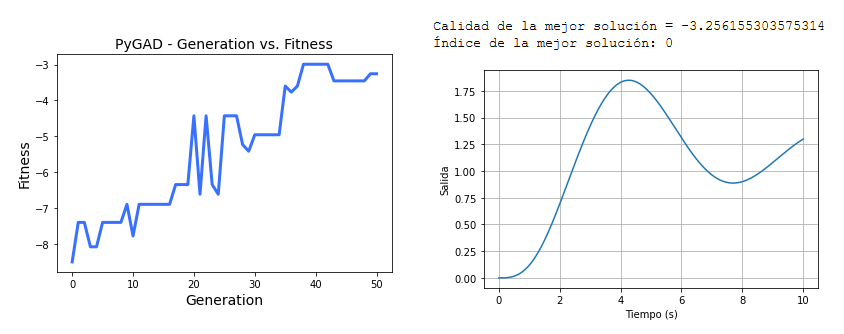

Se aprecia un aumento escalonado de la calidad. A su vez, se ve que se obtiene un valor muy cercano al 20% de sobreoscilación (se asienta en 1,5) y ocurre a los 4.5 s aproximadamente. Por lo tanto, se probará con aumentar el número de generaciones a 200. Con estas condiciones se obtuvo el resultado esperado. Esta población se guarda en el archivo `Optimizado.pkl` para su posterior revisión. Como se ve en la gráficas adjunta, se mantiene el comportamiento creciente escalonado de la calidad, y se logra sobrepasar la condición de parada a las 91 iteraciones. A su vez, la calidad de la mejor solución fue de -0.0663, por debajo de la condición de parada, lo que garantiza que los resultados obtenidos son los válidos.

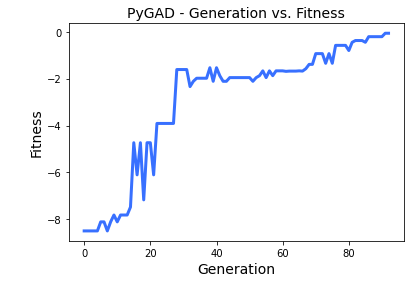

### Mejor individuo generado:

Ya con esto se obtuvo un individuo que cumple con las condiciones planteadas en el diseño. Se procederá a analizar gráficamente si se cumple el comportamiento esperado. Entonces, en la gráfica (a) de la Figura adjunta se ve que el valor de asentamiento de la salida ronda los 1.3 (escala de 200s). En la gráfica (b) se ve como el valor del sobreimpulso es de 1.5. Al comparar esos valores, se puede obtener que el porcentaje de sobreimpulso es entonces de aproximadamente el 20% (escala de 10s). En la gráfica (c) se tiene una escala de 5s, y se puede apreciar que el sobreimpulso ocurre levemente antes del segundo. Por lo tanto, se confirma que los valores de tiempo y magnitud del sobreimpulso recaen en el comportamiento esperado. 

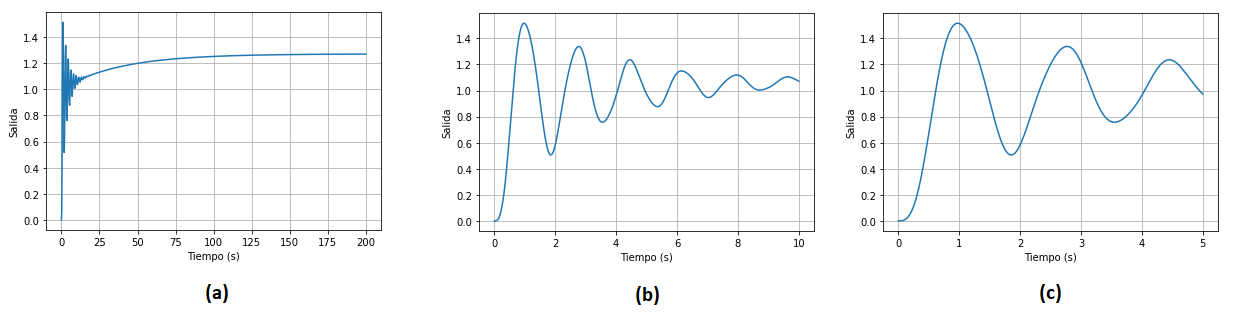

De la misma evaluación se obtiene entonces que el mejor cromosoma es:

\begin{equation}
    X = (-1.7124 , -4.9535 , -1.7442 , 0.1109 , -0.3945 , -2.1046 , 1.0015 , 1.7181 , 0.5223 , 0.4404 , 0.2082 , 0.3728 , 0.7028 , -2.5978 , -0.3201) 
\end{equation}

Matlab otorga que el tiempo y magnitud exacta del sobreimpulso para ese cromosoma es da: $t_p = 0.9681 s$ y $y_p = 19.3212\%$, que son valores muy aceptables y buenos paraq el problema. Por lo tanto, el cromosoma X supone una combinación de valores de las 15 constantes que cumplen las condiciones dictadas. No es la única.

Ya que para las últimas iteraciones se priorizó la selectividad, es de esperar que los resultados con calidades cercanas a las del caso anterior sean similares entre sí. Si se compara el fenotipo de los cuatro mejores genes de esta población final, se tendrá que: 

[-1.71237515 -4.95348963 -1.74416662  0.11091275 -0.39450991 -2.10459055
  1.00154041  1.71807514  0.52230826  0.44037606  0.20820449  0.37277306
  0.70284    -2.59778281 -0.32009094] -0.06626429162983027


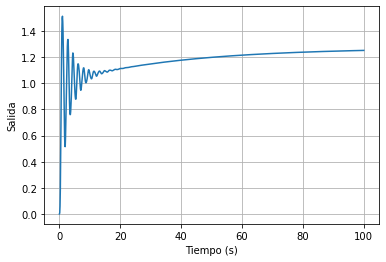

[-1.71237515 -4.95348963 -1.31864571  0.11091275 -0.39450991 -1.53675609
  1.00154041  1.71807514  0.55907179 -0.35327608  0.20820449  0.32156605
  0.70284    -3.01579614 -0.32009094] -0.2123986877432137


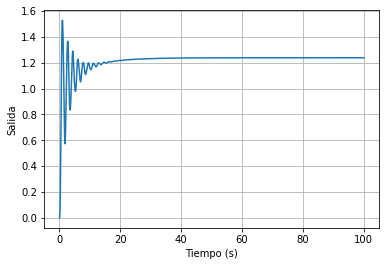

[-1.71237515 -4.95348963 -1.74416662  0.11091275 -0.39450991 -2.10459055
  1.00154041  1.99710518  0.52230826 -0.55275988  0.20820449  0.37277306
  0.70284    -2.59778281 -0.32009094] -0.34966223740285574


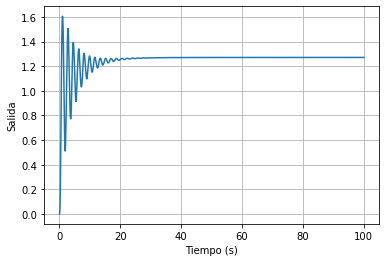

[-0.95359924 -4.95348963 -2.15950471  0.11091275 -0.39450991 -2.43270079
  0.60267249  1.1403529   0.51157999 -1.67478455  0.20820449  0.3242055
  0.70284    -3.01579614 -0.32009094] -0.4016765779524669


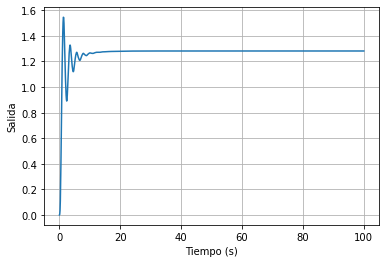

In [76]:
# Se carga el archivo optimizado
load_ga_instance = pygad.load(filename='Optimizado')

poblacion = load_ga_instance.population

# Se obtiene la mejor solución de la población
solution, solution_fitness, solution_idx = load_ga_instance.best_solution()

# Se imprimen los cuatro mejores resultados de toda la población en orden
for i in range(4):
    print(solution, solution_fitness)
    imprimirResultado(solution,100)
    poblacion = np.delete(poblacion, solution_idx, axis=0)
    temp = []
    for j in range(len(poblacion)):
        temp.append(funcCalidad(poblacion[j], 0))
    solution_fitness = np.nanmax(temp)
    solution_idx = np.where(solution_fitness == temp)
    solution = poblacion[solution_idx]
    solution = solution[0]

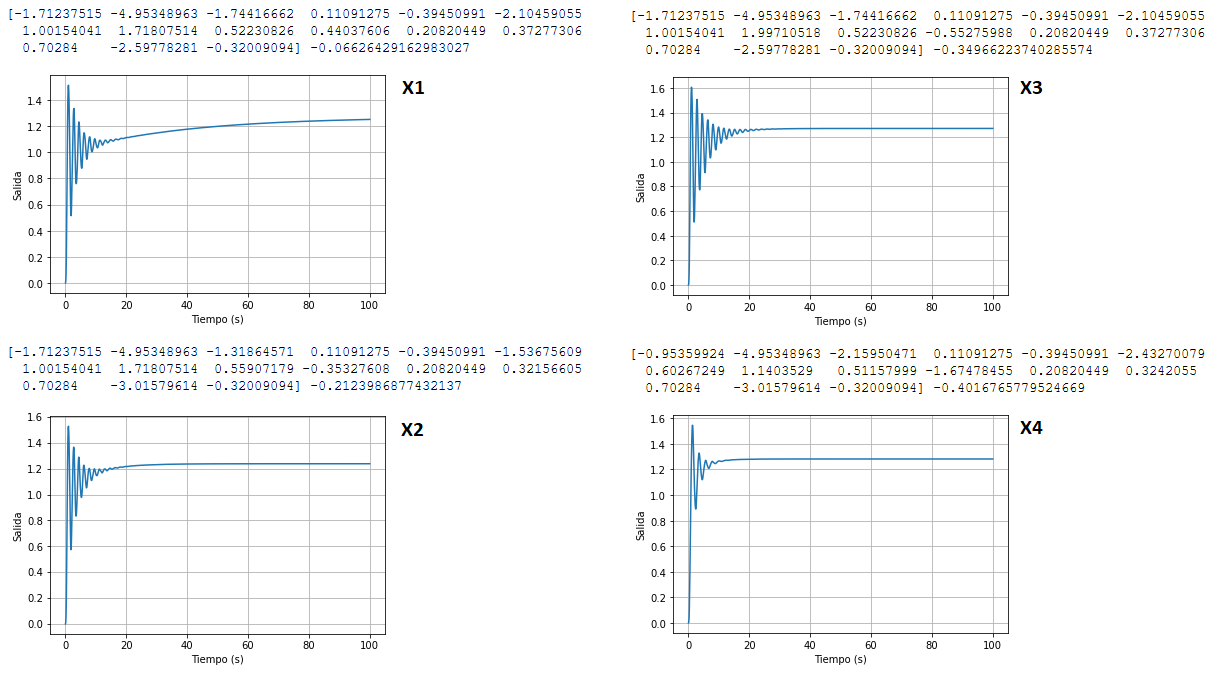

Como se aprecia, las gráficas son muy parecidas entre sí. Cabe resaltar que las oscilaciones de la cuarta solución se cancelan antes, pero para fines de este ejercicio solo interesa el tiempo y magnitud de la sobreoscilación. 
Según Matlab, se tiene que para:

$X_1 \Rightarrow t_p = 0.9681s$  y  $y_p = 19.3212\%$

$X_2 \Rightarrow t_p = 0.9706s$  y  $y_p = 23.6597\%$

$X_3 \Rightarrow t_p = 1.0262s$  y  $y_p = 26.4685\%$

$X_4 \Rightarrow t_p = 1.3571s$  y  $y_p = 20.8923\%$

Ya con estos valores es más claro el por qué $X_1$ obtuvo la mejor calidad. Por consiguiente, se puede observar que **la optimización del problema se logró satisfactoriamente.**


### Conclusiones

*   Con esta tarea los algoritmos evolutivos demostraron ser excelentes y sencillos de utilizar para optimizar problemas que dependan de muchísimas variables, y cuyo cálculo analítico es de engorroso a imposible de resolver. Se mostró el proceso para la implementación exitosa de un algoritmo evolutivo con PyGAD y el kernel de Matlab, así como de otras librerias de Python útiles para manejo de datos y graficación.
*   Para la optimización del cromosoma se aplicó un modelo evolutivo basado en la selección del mejor individuo según una función de calidad para garantizar el mejor resultado. Este modelo depende de las condiciones definidas en la población inicial, que en este caso no existía, por lo que tuvo que construirse desde cero e ir evolucionando hasta cumplir con lo esperado.
*   La correcta optimización del cromosoma depende de muchos hiperparámetros, pero se puede jugar con ellos para obtener una población inicial decente que sirva como base para mejores resultados.
*   Se logró encontrar un conjunto de 15 constantes que garantizaran una salida del sistema con comportamiento subamortiguado, ante una entrada de escalón por medio del sistema descrito por la función de transferencia $M(s)$, así como el tiempo y magnitud de sobreoscilación muy cercanos a los valores esperados de 1s y 20%. 